In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import pickle

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
q1.ef_amp = 0.1
print(f"{q1}\n{q2}")

Qubit(ro_freq=6.72742, ro_dur=4000, qubit_thr=[-10000, -600], IQ_angle=205, qubit_id=q1, ge_time=66.625, ef_ssm=-0.1859, ef_amp=0.1, ro_amp=0.6, RO_IF=None, ROIF=0.10272000000000059, RO_LO_pwr=16, RO_LO=6.6247, ge_amp=0.5, ef_time=77, ge_ssm=-0.114)
Qubit(ro_freq=6.6556, ro_dur=4000, qubit_thr=[-10000, 1900], IQ_angle=85, qubit_id=q2, ge_time=40.15374412400174, ef_ssm=-0.224, ef_amp=1, ro_amp=0.4, RO_IF=None, ROIF=0.030899999999999928, RO_LO_pwr=16, RO_LO=6.6247, ge_amp=1, ef_time=None, ge_ssm=-0.154)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [4]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ef(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df


def run_ssm_sweep(
    freq_start, freq_stop, freq_steps, reps, sweep_time, filename="21_ef_amp0.1.pkl"
):
    """
    Run an SSM sweep by performing Rabi experiments at each frequency.
    Save results to a file after each step.
    """
    frequencies = np.linspace(freq_start, freq_stop, freq_steps)
    num_steps = 51  # Number of time steps for Rabi oscillation

    # Initialize arrays to store results
    I_1, Q_1, I_2, Q_2 = np.zeros((4, freq_steps, num_steps))

    for i, freq in enumerate(frequencies):
        # Set the SSM frequency for qubit 1
        q1.ef_ssm = freq

        # Run Rabi experiment
        values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

        # Extract averaged I and Q values
        I_Q1 = values.rec_avg_vs_pats_1[0]
        Q_Q1 = values.rec_avg_vs_pats_1[1]
        I_Q2 = values.rec_avg_vs_pats_2[0]
        Q_Q2 = values.rec_avg_vs_pats_2[1]

        # Store results
        I_1[i] = I_Q1
        Q_1[i] = Q_Q1
        I_2[i] = I_Q2
        Q_2[i] = Q_Q2

        # Save results to file after each step
        with open(filename, "wb") as f:
            pickle.dump(
                {
                    "frequencies": frequencies,
                    "I_1": I_1,
                    "Q_1": Q_1,
                    "I_2": I_2,
                    "Q_2": Q_2,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{freq_steps} --------------------")

    return I_1, Q_1, I_2, Q_2


def run_amp_sweep(
    amp_start, amp_stop, amp_steps, reps, sweep_time, filename="ef_amp_sweep.pkl"
):
    """
    Run an amplitude sweep by performing Rabi experiments at the resonant frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
    amplitudes = np.linspace(amp_start, amp_stop, amp_steps)
    num_steps = 51  # Number of time steps for Rabi oscillation

    # Initialize arrays to store results
    I_1, Q_1, I_2, Q_2 = np.zeros((4, amp_steps, num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I_1 = saved_data["I_1"]
        Q_1 = saved_data["Q_1"]
        I_2 = saved_data["I_2"]
        Q_2 = saved_data["Q_2"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{amp_steps}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, amp_steps):
        amp = amplitudes[i]

        # Set the amplitude for qubit 1
        q1.ef_amp = amp

        # Run Rabi experiment
        values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

        # Extract averaged I and Q values
        I_Q1 = values.rec_avg_vs_pats_1[0]
        Q_Q1 = values.rec_avg_vs_pats_1[1]
        I_Q2 = values.rec_avg_vs_pats_2[0]
        Q_Q2 = values.rec_avg_vs_pats_2[1]

        # Store results
        I_1[i] = I_Q1
        Q_1[i] = Q_Q1
        I_2[i] = I_Q2
        Q_2[i] = Q_Q2

        # Save results to file after each step
        with open(filename, "wb") as f:
            pickle.dump(
                {
                    "amplitudes": amplitudes,
                    "I_1": I_1,
                    "Q_1": Q_1,
                    "I_2": I_2,
                    "Q_2": Q_2,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{amp_steps} --------------------")

    return I_1, Q_1, I_2, Q_2


def plot_chevron_freq(I_1, Q_1, frequencies, sweep_time, freq_start, freq_stop):
    """
    Plot the Rabi chevron results for I and Q channels of both qubits.
    """
    # Find resonant frequencies
    min_index_I1 = np.unravel_index(np.argmin(I_1), I_1.shape)
    min_index_Q1 = np.unravel_index(np.argmin(Q_1), Q_1.shape)
    rf_I1 = frequencies[min_index_I1[0]]
    rf_Q1 = frequencies[min_index_Q1[0]]

    # Plot I_1
    plt.figure()
    plt.imshow(I_1, extent=[0, sweep_time / 1000, freq_stop, freq_start], aspect="auto")
    plt.colorbar(label="I_1")
    plt.axhline(
        y=rf_I1, color="black", linestyle="--", label=f"Resonance: {rf_I1:.3f} GHz"
    )
    plt.ylabel("Frequency (GHz)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 I-channel Chevron")
    plt.legend()
    plt.show()

    # Plot Q_1
    plt.figure()
    plt.imshow(Q_1, extent=[0, sweep_time / 1000, freq_stop, freq_start], aspect="auto")
    plt.colorbar(label="Q_1")
    plt.axhline(
        y=rf_Q1, color="black", linestyle="--", label=f"Resonance: {rf_Q1:.3f} GHz"
    )
    plt.ylabel("Frequency (GHz)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 Q-channel Chevron")
    plt.legend()
    plt.show()


def plot_chevron_amp(I_1, Q_1, amplitudes, sweep_time, amp_start, amp_stop):
    """
    Plot the Rabi chevron results for I and Q channels, varying amplitude instead of frequency.
    """
    # Find resonant amplitudes
    min_index_I1 = np.unravel_index(np.argmin(I_1), I_1.shape)
    min_index_Q1 = np.unravel_index(np.argmin(Q_1), Q_1.shape)
    ra_I1 = amplitudes[min_index_I1[0]]  # Resonant amplitude for I
    ra_Q1 = amplitudes[min_index_Q1[0]]  # Resonant amplitude for Q

    # Plot I_1
    plt.figure()
    plt.imshow(I_1, extent=[0, sweep_time / 1000, amp_stop, amp_start], aspect="auto")
    plt.colorbar(label="I_1")
    plt.axhline(
        y=ra_I1,
        color="black",
        linestyle="--",
        label=f"Resonance: {ra_I1:.3f} (arb. units)",
    )
    plt.ylabel("Amplitude (arb. units)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 I-channel Chevron (Amplitude Sweep)")
    plt.legend()
    plt.show()

    # Plot Q_1
    plt.figure()
    plt.imshow(Q_1, extent=[0, sweep_time / 1000, amp_stop, amp_start], aspect="auto")
    plt.colorbar(label="Q_1")
    plt.axhline(
        y=ra_Q1,
        color="black",
        linestyle="--",
        label=f"Resonance: {ra_Q1:.3f} (arb. units)",
    )
    plt.ylabel("Amplitude (arb. units)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 Q-channel Chevron (Amplitude Sweep)")
    plt.legend()
    plt.show()

In [15]:
reps = 1000
sweep_time = 2000
freq_res = q1.ef_ssm
freq_diff = -0.1
freq_start = freq_res + freq_diff
freq_stop = freq_res - freq_diff
freq_steps = 50
amp_start = 0.1
amp_stop = 2
amp_steps = 130

# I_1, Q_1, _, _ = run_ssm_sweep(freq_start, freq_stop, freq_steps, reps, sweep_time)
I_1, Q_1, _, _ = run_amp_sweep(
    amp_start, amp_stop, amp_steps, reps, sweep_time
)  # this takes rougly 40 seconds per step

Loading existing data from ef_amp_sweep.pkl...
Resuming from step 25/130
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3


KeyboardInterrupt: 

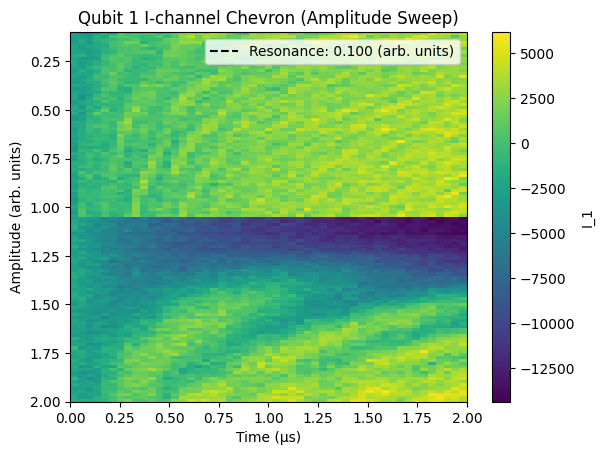

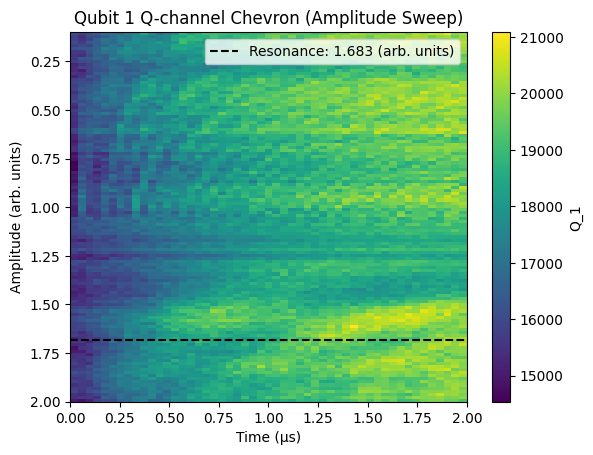

In [ ]:
frequencies = np.linspace(freq_start, freq_stop, freq_steps)
amplitudes = np.linspace(amp_start, amp_stop, amp_steps)
# plot_chevron_freq(I_1, Q_1, frequencies, sweep_time, freq_start, freq_stop)
plot_chevron_amp(I_1, Q_1, amplitudes, sweep_time, amp_start, amp_stop)